# Optimización de hiperparámetros utilizando [Optuna](https://optuna.readthedocs.io/en/stable/index.html)


Optuna es un marco de framework para la optimización de hiperparámetros. Es una herramienta de código abierto que te permite definir un espacio de búsqueda de hiperparámetros y una función objetivo que se evalúa en cada punto del espacio de búsqueda. Optuna realiza una búsqueda inteligente en el espacio de búsqueda de hiperparámetros para encontrar los valores óptimos para maximizar o minimizar la función objetivo.

Optuna utiliza algoritmos de optimización basados en árboles para buscar en el espacio de hiperparámetros de manera eficiente y ofrece una variedad de algoritmos de muestreo, incluidos los algoritmos de muestreo aleatorio y de búsqueda en grilla.

Optuna es una herramienta poderosa y fácil de usar para la optimización de hiperparámetros que puede ayudarte a mejorar el rendimiento de tus modelos de aprendizaje automático.

En Optuna tenemos que escribir la función objetivo a optimizar lo que puede ser algo positivo para utilizar el potencial de Python.  

Para poder utilizar esta biblioteca debemos conocer dos clases principales: [create_study()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html) y [trials()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html).

---------------------------------------------------

En este notebook vamos a realizar una prueba sencilla utilizando Optuna para optimizar el espacio de hiperparámetros de un algorítmo de clasificación sobre el dataset de Iris.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna

In [21]:
# Cargar el conjunto de datos de iris
iris = load_iris()
X, y = iris.data[:,:2], iris.target # Elijo solo dos features para graficar la frontera de decisión

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir la función de objetivo para la optimización de hiperparámetros
def objective(trial):
    """
    Objective function for optimizing hyperparameters of a RandomForestClassifier using Optuna.
    
    Args:
        trial: A `Trial` object from Optuna that contains the state of the optimization trial.
    
    Returns:
        The accuracy score of the RandomForestClassifier using the hyperparameters suggested by Optuna.
    """
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 5, 500)
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 500)
    min_samples_split = trial.suggest_float("min_samples_split", 0.01, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Crear el clasificador con los hiperparámetros sugeridos por Optuna
    clf = RandomForestClassifier(
                                    n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    criterion = criterion
                                    )
    
    # Entrenar el clasificador y calcular la precisión en el conjunto de prueba
    clf.fit(X_train, y_train)
    #y_pred = clf.predict(X_test)
    #score = accuracy_score(y_test, y_pred)

    score = cross_val_score(clf, X_train, y_train, cv=3)
    accuracy = score.mean()

    return accuracy

In [23]:
# Crear el estudio de Optuna y ejecutar la optimización

#sampler = optuna.samplers.RandomSampler(seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Imprimir los resultados de la optimización
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-04-28 23:29:40,944] A new study created in memory with name: no-name-2081a31b-91f9-48d7-9c52-28bc0622dc76
[I 2023-04-28 23:29:42,068] Trial 0 finished with value: 0.7416666666666667 and parameters: {'n_estimators': 190, 'criterion': 'gini', 'max_depth': 300, 'min_samples_split': 0.16445845403801215, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7416666666666667.
[I 2023-04-28 23:29:42,261] Trial 1 finished with value: 0.6999999999999998 and parameters: {'n_estimators': 33, 'criterion': 'gini', 'max_depth': 355, 'min_samples_split': 0.03037864935284442, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7416666666666667.
[I 2023-04-28 23:29:44,479] Trial 2 finished with value: 0.6999999999999998 and parameters: {'n_estimators': 417, 'criterion': 'gini', 'max_depth': 93, 'min_samples_split': 0.31119982052994233, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7416666666666667.
[I 2023-04-28 23:29:45,648] Trial 3 finished with value: 0.7083333333333334 and parame

Best trial: score 0.75, params {'n_estimators': 242, 'criterion': 'gini', 'max_depth': 38, 'min_samples_split': 0.14909690513996723, 'min_samples_leaf': 2}


c:\Users\alexb\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


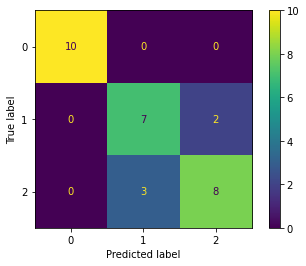

In [10]:
# Modelo final
clf_model = RandomForestClassifier(**study.best_params)
clf_model.fit(X_train, y_train)

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(clf_model, X_test, y_test)
plt.show()

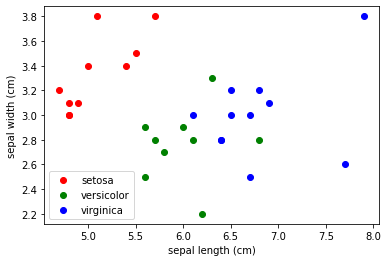

In [11]:
# crear un diccionario para asignar un color a cada clase
colors = {0: 'red', 1: 'green', 2: 'blue'}

# hacer el scatter plot
fig, ax = plt.subplots()
for i in range(len(iris.target_names)):
    ax.scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], c=colors[i], label=iris.target_names[i])
ax.legend()
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
plt.show()

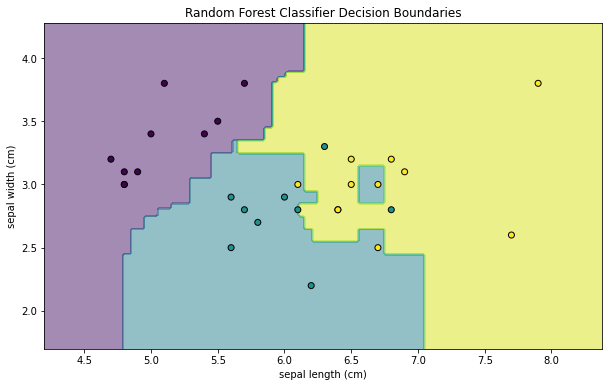

In [12]:
def plot_decision_boundary(clf, X, y, cmap='viridis'):
    """
    Plot the decision boundary of a classifier over a 2D dataset.
    
    Parameters:
    clf : classifier object
    A fitted classifier object with a predict method.
    
    X : array-like, shape (n_samples, 2)
    The input samples. Two features are expected to visualize the decision boundary.
    
    y : array-like, shape (n_samples,)
    The target values. A different color will be assigned to each class.
    
    cmap : str, default 'viridis'
    The colormap to be used in the scatter plot and decision boundary.
    
    Returns:
    None. The decision boundary plot is displayed using Matplotlib.
    
    """
    h = .02  # paso de la malla
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k')

# hacer el scatter plot y agregar las fronteras de decisión
plt.figure(figsize=(10, 6))
plot_decision_boundary(clf_model, X_test, y_test, cmap='viridis')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Random Forest Classifier Decision Boundaries')
plt.show()

## Random Sampler

In [13]:
optuna.visualization.plot_optimization_history(study)

In [15]:
optuna.visualization.plot_contour(study)

In [16]:
optuna.visualization.plot_contour(study, params=['max_depth', 'n_estimators'])

In [18]:
optuna.visualization.plot_parallel_coordinate(study)

In [19]:
optuna.visualization.plot_param_importances(study)

In [20]:
optuna.visualization.plot_slice(study)

# TPE

In [25]:
optuna.visualization.plot_optimization_history(study)

In [26]:
optuna.visualization.plot_contour(study)

In [27]:
optuna.visualization.plot_contour(study, params=['max_depth', 'n_estimators'])

In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
optuna.visualization.plot_param_importances(study)

In [30]:
optuna.visualization.plot_slice(study)

In [33]:
study.trials_dataframe().head(10)

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,0.741667,2023-04-28 23:29:40.946446,2023-04-28 23:29:42.068092,0 days 00:00:01.121646,gini,300,2,0.164458,190,COMPLETE
1,1,0.700000,2023-04-28 23:29:42.068092,2023-04-28 23:29:42.261239,0 days 00:00:00.193147,gini,355,10,0.030379,33,COMPLETE
2,2,0.700000,2023-04-28 23:29:42.261239,2023-04-28 23:29:44.479889,0 days 00:00:02.218650,gini,93,6,0.311200,417,COMPLETE
3,3,0.708333,2023-04-28 23:29:44.479889,2023-04-28 23:29:45.648176,0 days 00:00:01.168287,entropy,71,4,0.299223,219,COMPLETE
4,4,0.633333,2023-04-28 23:29:45.649391,2023-04-28 23:29:46.916812,0 days 00:00:01.267421,gini,258,1,0.596490,231,COMPLETE
5,5,0.333333,2023-04-28 23:29:46.917780,2023-04-28 23:29:48.454101,0 days 00:00:01.536321,gini,475,9,0.965976,306,COMPLETE
6,6,0.725000,2023-04-28 23:29:48.454101,2023-04-28 23:29:49.307693,0 days 00:00:00.853592,entropy,221,5,0.130818,156,COMPLETE
7,7,0.700000,2023-04-28 23:29:49.309835,2023-04-28 23:29:49.436506,0 days 00:00:00.126671,gini,332,6,0.318594,22,COMPLETE
8,8,0.333333,2023-04-28 23:29:49.437514,2023-04-28 23:29:50.936750,0 days 00:00:01.499236,entropy,388,9,0.940104,276,COMPLETE
9,9,0.741667,2023-04-28 23:29:50.936750,2023-04-28 23:29:52.529234,0 days 00:00:01.592484,gini,99,4,0.054775,301,COMPLETE


### Información complementaria

Para un mayor entendimiento del proceso que se ejecuta por detrás de este framework de optimización puede ser de utilidad leer el [paper](https://arxiv.org/pdf/1907.10902.pdf) de su publicación.

En los siguientes links podrán encontrar:  

[Espacios de HPs anidados con Optuna](https://www.kaggle.com/solegalli/nested-hyperparameter-spaces-with-optuna)  
[Optuna para optimizar una CNN](https://github.com/solegalli/hyperparameter-optimization/blob/master/Section-12-Optuna/03-Optimizing-a-CNN.ipynb)  
[Optuna para optimizar una CNN con distintos HPs en cada capa](https://github.com/solegalli/hyperparameter-optimization/blob/master/Section-12-Optuna/04-Optimizing-a-CNN-extended.ipynb)